In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
#from tqdm import tqdm_notebook as tqdm
import tensorflow.keras as K
from tensorflow.keras import backend as Kb
import numpy as np
import pandas as pd

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)


print(tf.__version__)
print(K.__version__)
print(tf.test.is_gpu_available())

1.14.0
2.2.4-tf
True


In [3]:
### loading mnist data
(train_images, y_train), (test_images, y_test) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')

train_images /= 255.
test_images /= 255.

# train_images[train_images >= .5] = 1.
# train_images[train_images < .5] = 0.
# test_images[test_images >= .5] = 1.
# test_images[test_images < .5] = 0.

# Test to train on only 10k images
#train_images = train_images[:10000]
#test_images = test_images[:10000]

# VQVAE

In [4]:
LATENT_K = 10
LATENT_D = 20
SIZE = 7

In [5]:
# Encoder
encoder_inputs = layers.Input(shape=(28,28,1), name='encoder_input')
x = layers.Conv2D(filters=8, kernel_size=3, padding='SAME',activation='relu',strides=(2,2))(encoder_inputs)
x = layers.Conv2D(filters=16, kernel_size=3, padding='SAME',activation='relu',strides=(2,2))(x)
z_e = layers.Conv2D(filters=LATENT_D,kernel_size=3,padding='SAME', activation=None,
                    strides=(1,1), name='encoded')(x)
encoder = K.Model(inputs=encoder_inputs, outputs=z_e,name='encoder')


# Latent
class Latent_Layer(K.layers.Layer):
    def __init__(self, latent_k, latent_d):
        super(Latent_Layer, self).__init__()
        self.d = latent_d
        self.k = latent_k
        
        
    def build(self, input_shape=None):
        rand_init = tf.uniform_unit_scaling_initializer()
        self.vectors = self.add_weight(shape=(self.k, self.d),
                             initializer=rand_init,
                             trainable=True, name='lookup')


#     def call(self, inputs):
#         lookup_ = tf.reshape(self.vectors, shape=(1, 1, self.k, self.d))
#         z_e = tf.expand_dims(inputs, -2)
#         dist = tf.norm(z_e - lookup_, axis=-1)
#         print(lookup_.shape, z_e.shape, dist.shape)
#         k_index = tf.argmin(dist, axis=-1)
#         z_q = tf.gather(self.vectors, k_index)
#         return z_q, k_index
        
    def call(self, inputs):
        # inputs has shape (batch, w, h, d)
        lookup_ = tf.reshape(self.vectors, shape=(1, 1, 1, self.k, self.d))
        z_e = tf.expand_dims(inputs, -2)
        dist = tf.norm(z_e - lookup_, axis=-1)
        k_index = tf.argmin(dist, axis=-1)
        k_index_one_hot = tf.one_hot(k_index, self.k)
        z_q = lookup_ * k_index_one_hot[..., None]
        z_q = tf.reduce_sum(z_q, axis=-2)
        return z_q, k_index
    
    def sample(self, indices):
        z_q = tf.gather(self.vectors, indices)
        return z_q


latent_inputs = tf.keras.Input(shape=(SIZE, SIZE,LATENT_D), name='z_sampling')
latent_layer = Latent_Layer(LATENT_K, LATENT_D)
latent_output = latent_layer(latent_inputs)
latent_sampler = K.Model(inputs=latent_inputs, outputs=latent_output, name='latent')


# Decoder
decoder_inputs = tf.keras.Input(shape=(SIZE,SIZE,LATENT_D), name='z_sampling')
y = layers.Conv2DTranspose(filters=8,kernel_size=4,strides=(2, 2), padding="SAME", 
                           activation='relu')(decoder_inputs)
y = layers.Conv2DTranspose(filters=16,kernel_size=4,strides=(2, 2), padding="SAME",
                           activation='relu')(y)
decoded = layers.Conv2DTranspose(filters=1,kernel_size=3,strides=(1, 1), padding="SAME",
                                 activation='sigmoid', name='output')(y)
decoder = K.Model(inputs=decoder_inputs, outputs=decoded, name='decoder')


# Define VAE model. Ouputs the generated images, encoder outputs z_e and discrete latent codes z_q
z_q, _ = latent_sampler(z_e)
decoder_inputs = z_e + tf.stop_gradient(z_q - z_e)  # copy the gradient from decoder directly 
                                                    # to the encoder in backward path
output = decoder(decoder_inputs)
latent_output = tf.stack([z_e, z_q], axis=-1)
latent_output = tf.identity(latent_output, name="latent_codes")
vq_vae = K.Model(inputs=encoder_inputs, outputs=[output, latent_output], name='vq-vae')


# Define custom losses for the multi-output VQVAE
def mse_loss(ground_truth, predictions):
    mse_loss = tf.reduce_mean((ground_truth - predictions)**2, name="mse_loss")
    return mse_loss

def latent_loss(dummy_ground_truth, outputs, alpha=1, beta=1):
    del dummy_ground_truth
    z_e, z_q = tf.split(outputs, 2, axis=-1)
    vq_loss = tf.reduce_mean((tf.stop_gradient(z_e) - z_q)**2)
    commit_loss = tf.reduce_mean((z_e - tf.stop_gradient(z_q))**2)
    latent_loss = tf.identity(alpha * (vq_loss + beta * commit_loss), name="latent_loss")
    return latent_loss    

vq_vae.compile(loss=[mse_loss, latent_loss], optimizer= K.optimizers.Adam(3e-4))
vq_vae.summary()

W0725 17:18:16.167867 46914115828480 deprecation.py:506] From /nfs/scistore12/chlgrp/soomranp/.local/lib/python3.5/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0725 17:18:16.234966 46914115828480 deprecation.py:323] From /nfs/scistore12/chlgrp/soomranp/.local/lib/python3.5/site-packages/tensorflow/python/util/deprecation.py:507: UniformUnitScaling.__init__ (from tensorflow.python.ops.init_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


Model: "vq-vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 8)    80          encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 16)     1168        conv2d[0][0]                     
__________________________________________________________________________________________________
encoded (Conv2D)                (None, 7, 7, 20)     2900        conv2d_1[0][0]                   
_____________________________________________________________________________________________

In [6]:
# Add a "dummy" ground-truth outputs (NONE) for the latent code loss
history = vq_vae.fit(train_images, [train_images, None], epochs=500, batch_size=128)

W0725 17:18:32.318518 46914115828480 deprecation.py:323] From /nfs/scistore12/chlgrp/soomranp/.local/lib/python3.5/site-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/500
60000/60000 [==============================] - 5s 88us/sample - loss: 0.1302 - decoder_loss: 0.0973 - tf_op_layer_latent_codes_loss: 0.0329
Epoch 2/500
60000/60000 [==============================] - 4s 72us/sample - loss: 0.0608 - decoder_loss: 0.0431 - tf_op_layer_latent_codes_loss: 0.0178
Epoch 3/500
60000/60000 [==============================] - 4s 67us/sample - loss: 0.0689 - decoder_loss: 0.0310 - tf_op_layer_latent_codes_loss: 0.0379
Epoch 4/500
60000/60000 [==============================] - 4s 65us/sample - loss: 0.0630 - decoder_loss: 0.0263 - tf_op_layer_latent_codes_loss: 0.0367
Epoch 5/500
60000/60000 [==============================] - 5s 77us/sample - loss: 0.0565 - decoder_loss: 0.0245 - tf_op_layer_latent_codes_loss: 0.0320
Epoch 6/500
60000/60000 [==============================] - 4s 73us/sample - loss: 0.0398 - decoder_loss: 0.0189 - tf_op_layer_latent_codes_loss: 0.0209
Epoch 7/500
60000/60000 [==============================] - 4s 64us/sample - loss: 0.0368

60000/60000 [==============================] - 4s 70us/sample - loss: 0.0246 - decoder_loss: 0.0089 - tf_op_layer_latent_codes_loss: 0.0157
Epoch 55/500
60000/60000 [==============================] - 4s 67us/sample - loss: 0.0246 - decoder_loss: 0.0089 - tf_op_layer_latent_codes_loss: 0.0157
Epoch 56/500
60000/60000 [==============================] - 4s 64us/sample - loss: 0.0246 - decoder_loss: 0.0088 - tf_op_layer_latent_codes_loss: 0.0158
Epoch 57/500
60000/60000 [==============================] - 4s 66us/sample - loss: 0.0246 - decoder_loss: 0.0088 - tf_op_layer_latent_codes_loss: 0.0158
Epoch 58/500
60000/60000 [==============================] - 4s 64us/sample - loss: 0.0246 - decoder_loss: 0.0088 - tf_op_layer_latent_codes_loss: 0.0158
Epoch 59/500
60000/60000 [==============================] - 4s 64us/sample - loss: 0.0246 - decoder_loss: 0.0088 - tf_op_layer_latent_codes_loss: 0.0158
Epoch 60/500
60000/60000 [==============================] - 4s 70us/sample - loss: 0.0246 - dec

KeyboardInterrupt: 

In [7]:
plt.plot(range(1, len(history.history["loss"]) + 1), history.history["loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VQVAE training")
plt.show()

NameError: name 'history' is not defined

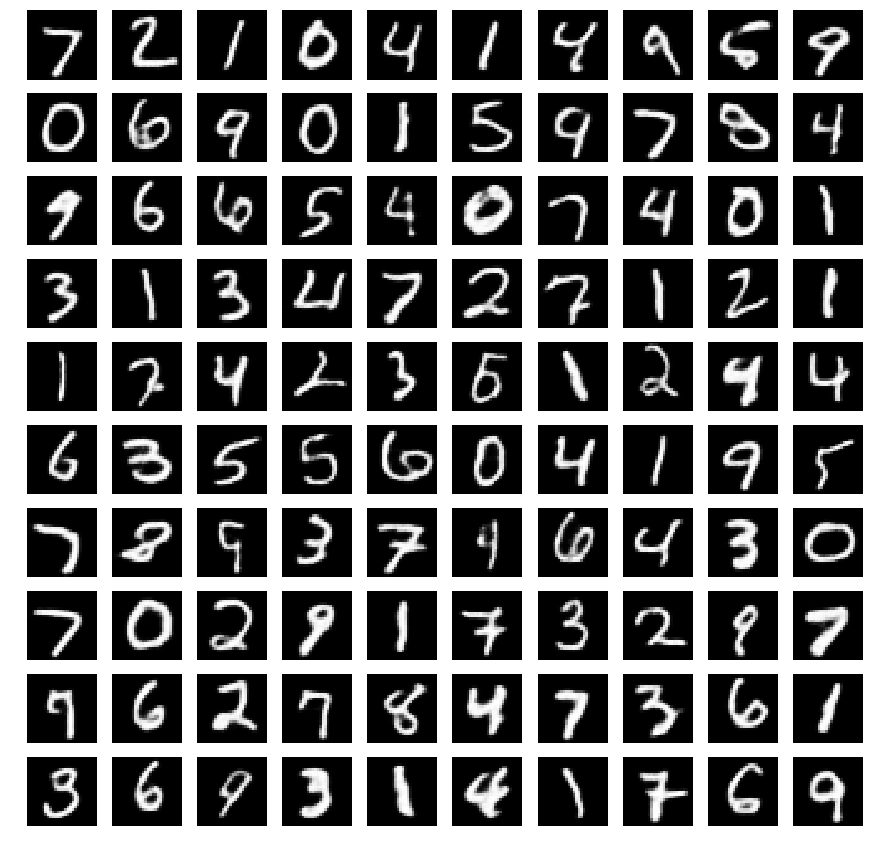

In [10]:
# reconstructions
def recons(n_row, n_col):
    n = n_row * n_col
    recons, latent = vq_vae.predict(test_images[:n,:,:,:])
    plt.figure(figsize=(15, 15))
    for i in range(n):
        plt.subplot(n_row, n_col, i+1)
        plt.imshow(recons[i,:,:,0], cmap='gray')
        plt.axis('off')
    plt.show()
    
recons(10, 10)

# PixelCNN Prior

Inspired from https://github.com/hiwonjoon/tf-vqvae/blob/master/model.py#L187

In [11]:
# Load indices of latent codes for the whole training set
#This will be the training set for the pixelcnn prior
_, train_embeddings_indices = latent_sampler.predict(encoder.predict(train_images))
train_embeddings_indices.shape

(60000, 7, 7)

In [12]:
class GatedCNN(K.layers.Layer):
    def __init__(self, W_shape, horizontal, gated=True, payload=False, mask=None, activation=True):
        super(GatedCNN, self).__init__()
        self.W_shape = W_shape
        self.payload = payload
        self.mask = mask
        self.activation = activation
        self.gated = gated
        self.horizontal = horizontal
        
    def apply_mask(self, W, mask, shape):
        if mask:
            filter_mid_x = shape[0]//2
            filter_mid_y = shape[1]//2
            mask_filter = np.ones(shape, dtype=np.float32)
            
            if self.horizontal:
                mask_filter[filter_mid_x, filter_mid_y+1:, :, :] = 0. # All columns after center in center row to 0
                mask_filter[filter_mid_x+1:, :, :, :] = 0. # rows after middle row to 0
                
            else:
                if mask == 'a':
                    mask_filter[filter_mid_x:, :, :, :] = 0.
                else:
                    mask_filter[filter_mid_x+1:, :, :, :] = 0.

            if mask == 'a':
                mask_filter[filter_mid_x, filter_mid_y, :, :] = 0.

            return W * mask_filter 
        else:
            return W
        
        
    def build(self, input_shape):
        if self.payload:
            input_shape = input_shape[0]
        in_dim = int(input_shape[-1])
        W_shape = [self.W_shape[0], self.W_shape[1], in_dim, self.W_shape[2]]  
        b_shape = [self.W_shape[2],]   
        
        self.W_f = self.add_weight("v_W", W_shape, trainable=True)
        self.W_f = self.apply_mask(self.W_f, self.mask, W_shape)
        self.b_f = self.add_weight("v_b", b_shape, trainable=True)
        if self.gated:
            self.W_g = self.add_weight("h_W", W_shape, trainable=True)
            self.W_g = self.apply_mask(self.W_g, self.mask, W_shape)
            self.b_g = self.add_weight("h_b", b_shape, trainable=True)
    
    
    def call(self, inputs):
        if self.payload:
            fan_in = inputs[0]
            payload = inputs[1]
        else:
            fan_in = inputs
            payload = None
            
        conv_f = Kb.conv2d(fan_in, self.W_f, strides=[1,1,1,1], padding='same')
        conv_f = conv_f + self.b_f
        if self.gated:
            conv_g = Kb.conv2d(fan_in, self.W_g, strides=[1,1,1,1], padding='same')
            conv_g = conv_g + self.b_g
            if payload is not None:
                conv_f += payload
                conv_g += payload
            return tf.multiply(tf.tanh(conv_f), tf.sigmoid(conv_g))     
        else:
            if self.activation:
                conv_f = tf.nn.relu(conv_f)
            return conv_f

In [14]:
# https://github.com/hiwonjoon/tf-vqvae/blob/master/mnist.py#L272
NUM_LAYERS = 12
NUM_FEATURE_MAPS = 32

pixelcnn_prior_inputs = layers.Input(shape=(SIZE, SIZE), name='pixelcnn_prior_inputs', dtype=tf.int32)
zq = latent_layer.sample(pixelcnn_prior_inputs)
zq = tf.stop_gradient(zq)

v_stack_in, h_stack_in = zq, zq
for i in range(NUM_LAYERS):
    filter_size = 3 if i > 0 else 7
    mask = 'b' if i > 0 else 'a'
    residual = True if i > 0 else False

    v_stack_in = GatedCNN([filter_size, filter_size,  NUM_FEATURE_MAPS], horizontal=False, mask=mask)(v_stack_in)
    v_stack_1 = GatedCNN([1, 1, NUM_FEATURE_MAPS], horizontal=False, gated=False, mask=None)(v_stack_in)

    h_stack = GatedCNN([1, filter_size,  NUM_FEATURE_MAPS], horizontal=True, payload=True, mask=mask)([h_stack_in, v_stack_in])    
    h_stack_1 = GatedCNN([1, 1,  NUM_FEATURE_MAPS], horizontal=True, gated=False, mask=None)(h_stack)
    if residual:
        h_stack_1 += h_stack_in # Residual connection

    h_stack_in = h_stack_1


fc1 = GatedCNN([1, 1,  NUM_FEATURE_MAPS], horizontal=True, gated=False, mask='b')(h_stack_in)
fc2 = GatedCNN([1, 1, LATENT_K], horizontal=True, gated=False, mask='b', activation=False)(fc1)

prior_pixelcnn = K.Model(inputs=pixelcnn_prior_inputs, outputs=fc2, name='pixelcnn-prior')
prior_pixelcnn.summary()

# Distribution to sample from the pixelcnn
dist = tf.distributions.Categorical(logits=fc2)
sampled = dist.sample()
log_prob = dist.log_prob(sampled)
prior_sampler = K.Model(inputs=pixelcnn_prior_inputs, outputs=sampled, name='pixelcnn-prior-sampler')

W0725 17:31:00.257164 46914115828480 deprecation.py:323] From <ipython-input-14-a2cf4b038d4f>:33: Categorical.__init__ (from tensorflow.python.ops.distributions.categorical) is deprecated and will be removed after 2019-01-01.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
W0725 17:31:00.269719 46914115828480 deprecation.py:323] From /nfs/scistore12/chlgrp/soomranp/.local/lib/python3.5/site-packages/tensorflow/python/ops/distributions/categorical.py:242: Distribution.__init__ (from tensorflow.python.ops.distributions.distribution) is deprecated and will be removed after 2019-01-01.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.dis

Model: "pixelcnn-prior"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
pixelcnn_prior_inputs (InputLay [(None, 7, 7)]       0                                            
__________________________________________________________________________________________________
tf_op_layer_Gather (TensorFlowO [(None, 7, 7, 20)]   0           pixelcnn_prior_inputs[0][0]      
__________________________________________________________________________________________________
tf_op_layer_Identity (TensorFlo [(None, 7, 7, 20)]   0           tf_op_layer_Gather[0][0]         
__________________________________________________________________________________________________
tf_op_layer_StopGradient_1 (Ten [(None, 7, 7, 20)]   0           tf_op_layer_Identity[0][0]       
_____________________________________________________________________________________

In [ ]:
# Train the PixelCNN
prior_pixelcnn.compile(loss=K.losses.SparseCategoricalCrossentropy(from_logits=True), 
                       optimizer=K.optimizers.Adam(2e-4))
prior_history = prior_pixelcnn.fit(train_embeddings_indices, train_embeddings_indices, 
                                   epochs=500, batch_size=128)

Epoch 1/500
60000/60000 [==============================] - 19s 310us/sample - loss: 1.6912
Epoch 2/500
60000/60000 [==============================] - 17s 287us/sample - loss: 1.3349
Epoch 3/500
60000/60000 [==============================] - 17s 290us/sample - loss: 1.2086
Epoch 4/500
60000/60000 [==============================] - 17s 283us/sample - loss: 1.1324
Epoch 5/500
60000/60000 [==============================] - 17s 275us/sample - loss: 1.0833
Epoch 6/500
60000/60000 [==============================] - 17s 281us/sample - loss: 1.0545
Epoch 7/500
60000/60000 [==============================] - ETA: 0s - loss: 1.032 - 17s 283us/sample - loss: 1.0325
Epoch 8/500
60000/60000 [==============================] - 17s 276us/sample - loss: 1.0144
Epoch 9/500
60000/60000 [==============================] - 16s 263us/sample - loss: 0.9990
Epoch 10/500
60000/60000 [==============================] - 17s 278us/sample - loss: 0.9860
Epoch 11/500
60000/60000 [==============================] - 18s 3

60000/60000 [==============================] - 18s 299us/sample - loss: 0.7942
Epoch 178/500
60000/60000 [==============================] - 17s 286us/sample - loss: 0.7941
Epoch 179/500
60000/60000 [==============================] - 18s 293us/sample - loss: 0.7941
Epoch 180/500
60000/60000 [==============================] - 16s 266us/sample - loss: 0.7936
Epoch 181/500
60000/60000 [==============================] - 15s 251us/sample - loss: 0.7934
Epoch 182/500
60000/60000 [==============================] - 16s 260us/sample - loss: 0.7934
Epoch 183/500
60000/60000 [==============================] - 17s 281us/sample - loss: 0.7930
Epoch 184/500
60000/60000 [==============================] - 17s 285us/sample - loss: 0.7929
Epoch 185/500
60000/60000 [==============================] - 18s 295us/sample - loss: 0.7926
Epoch 186/500
60000/60000 [==============================] - 17s 290us/sample - loss: 0.7923
Epoch 187/500
60000/60000 [==============================] - 16s 271us/sample - loss

60000/60000 [==============================] - 17s 285us/sample - loss: 0.7788
Epoch 266/500
60000/60000 [==============================] - 18s 296us/sample - loss: 0.7786
Epoch 267/500
60000/60000 [==============================] - 17s 283us/sample - loss: 0.7785
Epoch 268/500
60000/60000 [==============================] - 18s 295us/sample - loss: 0.7785
Epoch 269/500
60000/60000 [==============================] - 18s 294us/sample - loss: 0.7782
Epoch 270/500
60000/60000 [==============================] - 17s 291us/sample - loss: 0.7781
Epoch 271/500
60000/60000 [==============================] - 17s 289us/sample - loss: 0.7779
Epoch 272/500
60000/60000 [==============================] - 17s 284us/sample - loss: 0.7777
Epoch 273/500
60000/60000 [==============================] - 17s 289us/sample - loss: 0.7777
Epoch 274/500
60000/60000 [==============================] - 17s 279us/sample - loss: 0.7775
Epoch 275/500
60000/60000 [==============================] - 17s 288us/sample - loss

In [19]:
prior_history = prior_pixelcnn.fit(train_embeddings_indices, train_embeddings_indices, 
                                   epochs=500, batch_size=128)

Epoch 1/500
19072/60000 [========>.....................] - ETA: 11s - loss: 0.7422

KeyboardInterrupt: 

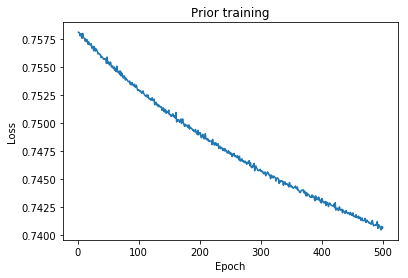

In [20]:
plt.plot(range(1, len(prior_history.history["loss"]) + 1), prior_history.history["loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Prior training")
plt.show()

In [ ]:
#Check reconstructions on the training set
n = 5
sampled = prior_sampler.predict(train_embeddings_indices[:n])
for i in range(n):
    print(train_embeddings_indices[i])
    print(sampled[i])
    print()

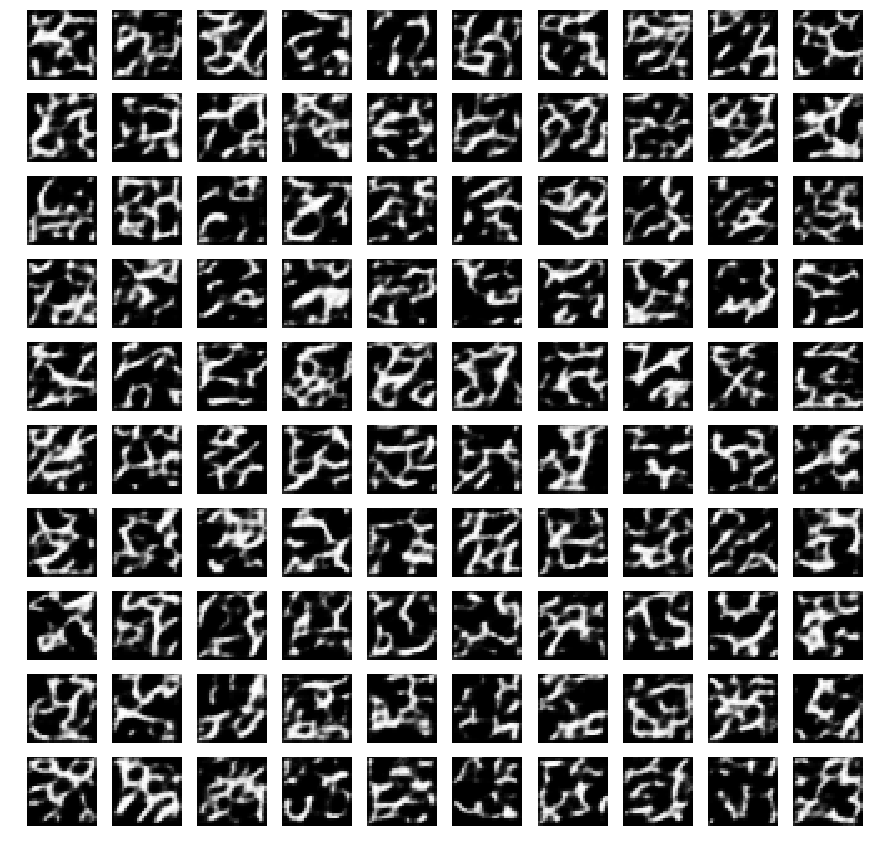

Log_prob: 0.0


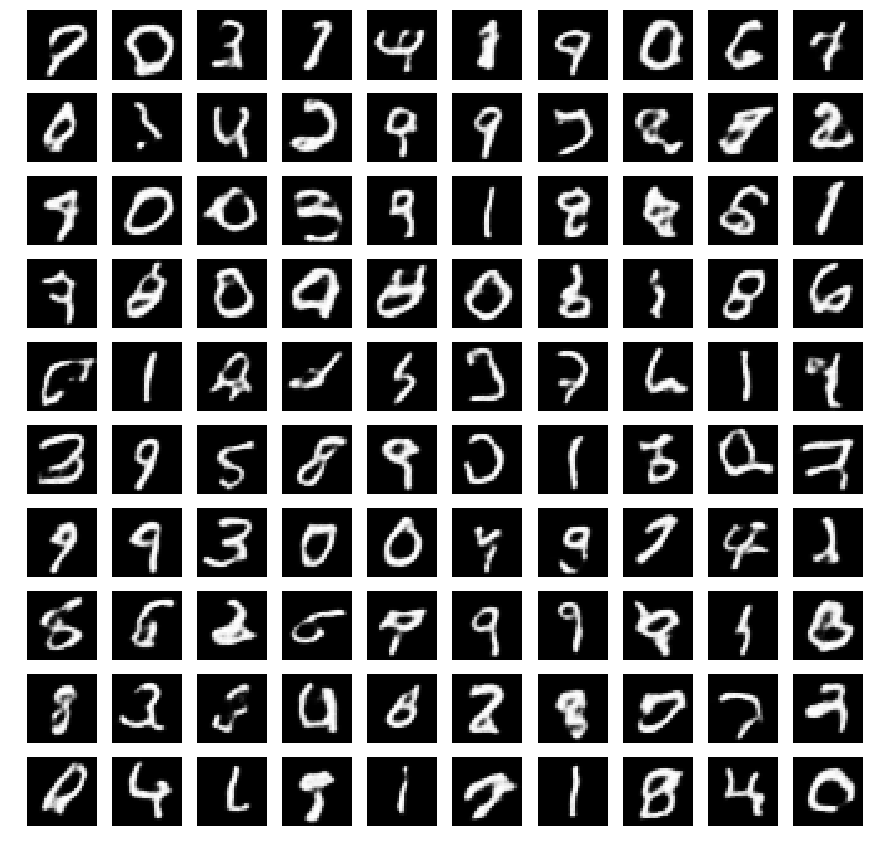

In [21]:
# Generation
def sample_from_prior(batch_size=1):
    X = np.zeros((batch_size, SIZE, SIZE), dtype=np.int32)
    log_probs = np.zeros((batch_size,))
    for i in range(X.shape[1]):
        for j in range(X.shape[2]):
            sampled = prior_sampler.predict(X)
            X[:, i, j] = sampled[:, i, j]
    print("Log_prob:", np.mean(log_probs))
    return X
            
def generate(n_row, n_col, prior=False):
    n = n_col*n_row
    if not prior:
        rand_vector = np.random.randint(0, LATENT_K, size=(n, SIZE, SIZE))
    else:
        rand_vector = sample_from_prior(n)
    embeds = latent_layer.sample(rand_vector)
    generated = decoder.predict(embeds, steps=1)
    plt.figure(figsize=(15, 15))
    for i in range(n):
        plt.subplot(n_row,n_col,i+1)
        plt.imshow(generated[i,:,:,0], cmap='gray')
        plt.axis('off')
    plt.show()
    
generate(10, 10, prior=False)
generate(10, 10, prior=True)